PART B

In [29]:
# Importing the necessary libraries

import numpy as np
import geopandas
import pandas as pd
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder

### Importing Zomato DataFrame for Sydney

In [30]:
df_main = pd.read_csv("./data/zomato_df_final_data.csv")

### Dropping Unwanted columns

The dataset appears to contain information where each entry includes an address, link, phone number, and title, which are standard details for a location or business. However, it's unclear why the dataset also includes fields for color and cuisine_color, as they may not be relevant for the current analysis. For the first regression analysis, we will exclude the rating_text field, as it likely does not contribute useful numerical data for regression purposes. Additionally, the lat (latitude) and lng (longitude) fields will not be necessary since we'll be using subzone as a geographic identifier instead.

In [31]:
df = df_main.drop(columns = ["address", "link", "phone", "title", "color", "cuisine_color", "lat", "lng"], axis = 1)

In [32]:
df.head(3)

,cost,cuisine,rating_number,rating_text,subzone,type,votes,groupon,cost_2
0,50.0,"['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean']",4.0,Very Good,CBD,['Casual Dining'],1311.0,False,5.243902
1,80.0,"['Cafe', 'Coffee and Tea', 'Salad', 'Poké']",4.6,Excellent,"The Grounds of Alexandria, Alexandria",['Café'],3236.0,False,7.560976
2,120.0,['Japanese'],4.9,Excellent,"The Star, Pyrmont",['Fine Dining'],1227.0,False,10.650407


### Feature Engineering

In [33]:
# Display the count of missing values in each column with better formatting
missing_values = df.isna().sum()

# Display only the columns with missing values
missing_values[missing_values > 0]


cost              346
rating_number    3316
rating_text      3316
type               48
votes            3316
cost_2            346
dtype: int64

### Fixing Subzone Column
Subzone has comma separate values which are not correct. We need to extract Suburbs names only from those values and fix the column

In [34]:
# Count the number of rows where the 'subzone' column contains a comma
comma_subzone_count = df['subzone'].str.contains(",").sum()

# Display the result
print(f"Number of subzones containing a comma: {comma_subzone_count}")

# Get the number of unique subzones in the dataset
unique_subzones_count = df_main['subzone'].nunique()

# Display the result
print(f"Number of unique subzones: {unique_subzones_count}")

df['subzone'] = df['subzone'].apply(lambda x: x.split(',')[-1].strip() if ',' in x else x)

print(f"Number of subzones after cleanup: {len(df.subzone.unique())}")

Number of subzones containing a comma: 1359
Number of unique subzones: 572
Number of subzones after cleanup: 339


### Finding Null / NaN values
Lets find NULL or NaN values in out dataset

In [35]:
df.isna().sum()
df.dropna(subset=['rating_number'], inplace=True)
df.isna().sum()

cost             103
cuisine            0
rating_number      0
rating_text        0
subzone            0
type              21
votes              0
groupon            0
cost_2           103
dtype: int64

Perform Label-encoding on Subzone column:

In [36]:
label_encoder = LabelEncoder()
df['encoded_subzone'] = label_encoder.fit_transform(df['subzone'])

df['encoded_subzone'].head(5)

0     46
1      1
2    225
3     68
4     66
Name: encoded_subzone, dtype: int64

### Fixing Cost and Cost_2 Columns
Fill missing values in 'cost' and 'cost_2' columns with the mean of their respective 'subzone' group for standardization

In [37]:
df[['cost', 'cost_2']] = df.groupby('subzone')[['cost', 'cost_2']].transform(lambda x: x.fillna(x.mean()))

# Drop the 'subzone' column
df.drop(columns='subzone', inplace=True)

df.loc[6]

cost                                             120.0
cuisine            ['Cantonese', 'Chinese', 'Yum Cha']
rating_number                                      4.5
rating_text                                  Excellent
type                                 ['Casual Dining']
votes                                           1623.0
groupon                                          False
cost_2                                       10.650407
encoded_subzone                                     46
Name: 6, dtype: object

### Dropping Cuisine column
Drop the 'cuisine' column because creating 135 one-hot-encoded features is impractical, and 'rating' is not strongly correlated with 'cuisine'


In [38]:
# Drop the 'cuisine' column
df.drop(columns='cuisine', inplace=True)

### Fix Type Column:
We need to fix type coluumn as it has missing value and perform one-hot encoding the same. We can fix this by most frequently used value. We would like have to fix the string comma separated values.

In [39]:
# Fill missing values in the 'type' column with the most common type
frequently_used = df["type"].mode()[0]
df["type"].fillna(frequently_used).head(5)

0         ['Casual Dining']
1                  ['Café']
2           ['Fine Dining']
3    ['Fine Dining', 'Bar']
4         ['Casual Dining']
Name: type, dtype: object

### ONE HOT ENCODING

In [40]:
most_frequent = df["type"].mode()[0]
df["type"].fillna(most_frequent, inplace=True)

for value in df["type"]:
    get_type(value)

import re
types = set()

#custom function to check all the values
def get_type(str):
    pattern = r',\s*' #removing comma(,) followed by immediate space
    cleaned_text = re.sub(pattern, '-', str)
    pattern2 = r'[\'\[\],]'
    cleaned_text = re.sub(pattern2, "", cleaned_text)
    temp = cleaned_text.split("-")
    for type in temp:
        types.add(type)

# one hot encoding
for dining_type in types:
    df[f"is_{dining_type}"] = df['type'].apply(lambda x: 1 if dining_type in x else 0)
df.drop('type', axis=1, inplace=True)

/tmp/ipykernel_451998/3505674292.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["type"].fillna(most_frequent, inplace=True)


### MODEL 1: REGRESSION ANALYSIS

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# X,y
X = df.drop(columns=['rating_number', 'rating_text'])  # Features
y = df['rating_number']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model_regression_1 = LinearRegression()
model_regression_1.fit(X_train, y_train)

# predictions
y_pred = model_regression_1.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.15023008107092764
R-squared: 0.2375261151490855


### MODEL 2: LINEAR GRADIENT DESCENT 

In [44]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_regression_2 = SGDRegressor(loss="squared_error", max_iter=1000, random_state=0)
model_regression_2.fit(X_train_scaled, y_train)

y_pred = model_regression_2.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.1614347029693049
R-squared: 0.18065846569938682



### MODEL 3: Classification


In [45]:
df.dropna(subset=["rating_text"], inplace=True)

class_mapping = {
    "Poor": 1,
    "Average": 1,
    "Good": 2,
    "Very Good": 2,
    "Excellent": 2
}
df["binary_rating"] = df["rating_text"].map(class_mapping)
df = df.drop(columns = ["rating_text"], axis = 1)

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


X = df.drop(columns=['binary_rating'])  # Features
y = df['binary_rating']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

classification_model_logistic_regression_3 = LogisticRegression()
classification_model_logistic_regression_3.fit(X_train, y_train)

# predictions
y_pred = classification_model_logistic_regression_3.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9923451635351427
Precision: 0.9926160337552743
Recall: 0.9957671957671957
F1 Score: 0.99418911780243
ROC AUC Score: 0.9907697767453865
Confusion Matrix:
 [[941   4]
 [  7 485]]


/home/luffy/dev/bilal-analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### CONFUSION MATRIX

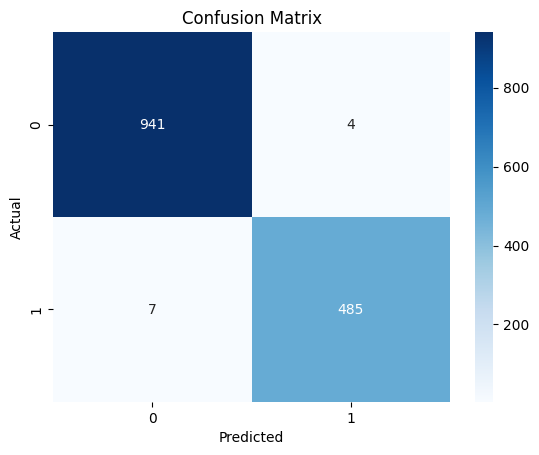

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows a binary classification model's performance, with the actual values on the y-axis and predicted values on the x-axis. The model correctly classified 941 instances of class 0 (true negatives) and 485 instances of class 1 (true positives). There were 4 false positives (class 0 misclassified as class 1) and 7 false negatives (class 1 misclassified as class 0). The matrix indicates that the model is highly accurate, with a low number of misclassifications.